# KNN Model

In [71]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

### Data Preprocessing

In [72]:
df = pd.read_csv('../cleaning-preprocessing/flight-delay-dataset.csv')
df.head(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,...,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,...,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,...,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,...,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,...,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,...,32,58,W,24,35,29.91,Fair / Windy,9,17,13


In [73]:
# Remove NAs
df.isna().sum()
df.dropna(inplace=True)

# Remove TAIL_NUM and TAXI_OUT
df.drop(columns=['TAIL_NUM', 'TAXI_OUT', 'DEP_TIME_M'], inplace=True)

# Convert DEW_POINT to int
df['Dew Point'] = df['Dew Point'].astype(int)

# Encode categorical variables
columns_to_encode = ['OP_UNIQUE_CARRIER', 'DEST', 'Wind', 'Condition']
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

# Remove all values beyond 3 standard deviations from the mean
mean_dep_delay = df_encoded['DEP_DELAY'].mean()
std_dep_delay = df_encoded['DEP_DELAY'].std()
upper_threshold = mean_dep_delay + (3 * std_dep_delay)
df_encoded = df_encoded[df_encoded['DEP_DELAY'] <= upper_threshold]

# Remove all values below 0
df = df_encoded[df_encoded['DEP_DELAY'] >= 15]

### Feature Analysis (Filtering)

In [74]:
# Considering any flight is delay after 15 minutes
df = df[df['DEP_DELAY'] >= 15]

# Filtering df with Features Outiler Requirments (From training_feature_analysis)
df = df[df['CRS_ELAPSED_TIME'] < 600]
df = df[df['DISTANCE'] < 4000]
df = df[df['CRS_ARR_M'] > 400]

### Transformation Testing

In [75]:
print(f" DEP_DELAY Skewness Score: {df['DEP_DELAY'].skew()}")  # If > 0.5 or < -0.5, transformation is needed

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1

df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])  # log1p avoids log(0) issue
print(f" Log Skewness Score: {df['DEP_DELAY_log'].skew()}")

df['DEP_DELAY_sqrt'] = np.sqrt(df['DEP_DELAY_shifted']) # sqrt version 
print(f" Sqrt Skewness Score: {df['DEP_DELAY_sqrt'].skew()}")

 DEP_DELAY Skewness Score: 1.1074957156949266
 Log Skewness Score: -0.33623533656155286
 Sqrt Skewness Score: 0.409902935429171


In [76]:
X = df.drop(columns=['DEP_DELAY_sqrt','DEP_DELAY_log', 'DEP_DELAY','DEP_DELAY_shifted']) #Dropping DEP_DELAY Log/Sqrt transform cols

# Using Single Log Transformation
y = df['DEP_DELAY']  # Target variable

y.head(3)

2      40
14    108
36     29
Name: DEP_DELAY, dtype: int64

### Feature Selection

In [77]:
k_num_features = 20

In [78]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df)

Selected Features:
                     Feature    F-Score
4                    sch_dep  54.263258
6       OP_UNIQUE_CARRIER_DL  19.403768
1                   DISTANCE  19.164016
0           CRS_ELAPSED_TIME  19.061150
3                   Pressure  13.370950
18  Condition_Cloudy / Windy  11.508220
8                   DEST_BOS  10.000492
17                    Wind_W   7.781376
2                 Wind Speed   7.270000
10                  DEST_BUF   5.859955
13                  DEST_SLC   5.714692
15                  Wind_ENE   5.376252
14                    Wind_E   4.647737
7       OP_UNIQUE_CARRIER_MQ   4.567116
19            Condition_Rain   4.246528
11                  DEST_CVG   3.790780
12                  DEST_SAV   3.781041
16                   Wind_NE   3.638028
9                   DEST_BTV   3.550961
5       OP_UNIQUE_CARRIER_9E   3.536989


In [79]:
selected_num_feature = 9 #Selecting F-score greater than 5

In [80]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = selected_num_feature  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df)

Selected Features:
                    Feature    F-Score
4                   sch_dep  54.263258
5      OP_UNIQUE_CARRIER_DL  19.403768
1                  DISTANCE  19.164016
0          CRS_ELAPSED_TIME  19.061150
3                  Pressure  13.370950
8  Condition_Cloudy / Windy  11.508220
6                  DEST_BOS  10.000492
7                    Wind_W   7.781376
2                Wind Speed   7.270000


### Split Training and Test Set

In [81]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 42)

### Model Training

In [82]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=10, metric='manhattan', weights='distance')
regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance')

### Trasnform Back

In [83]:
y_pred = regressor.predict(X_test)

### Results

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Average Prediction {np.mean(y_pred)}")


Model Performance Metrics:
Mean Squared Error (MSE): 691.41
Mean Absolute Error (MAE): 20.64
Average Prediction 42.859942556738005


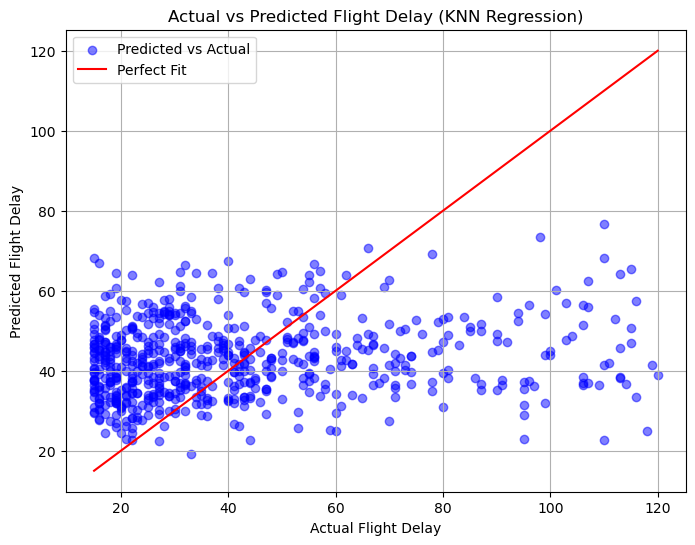

In [85]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [86]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(3, 11)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Best k:", grid.best_params_)

Best k: {'n_neighbors': 10}
